In [9]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

### Load Scaled Clustering Features

This cell loads the pre-scaled feature matrix for clustering.


In [10]:
df_scaled = pd.read_csv("../data/processed/features_for_clustering_scaled.csv")
df_scaled.shape

(8559, 140)

In [7]:
pca = PCA(n_components=0.95, random_state=42)

pca.fit(df_scaled)
X_pca = pca.transform(df_scaled)

print("Original shape:", df_scaled.shape)
print("After PCA shape:", X_pca.shape)

print("Total explained variance:", sum(pca.explained_variance_ratio_))
print("Number of components:", pca.n_components_)

df_pca = pd.DataFrame(
    X_pca,
    columns=[f"PC{i+1}" for i in range(X_pca.shape[1])]
)

df_pca.head()

Original shape: (8559, 140)
After PCA shape: (8559, 42)
Total explained variance: 0.9500622397818945
Number of components: 42


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42
0,-3.830402,-2.092136,1.254415,-1.278514,-0.751857,2.125007,0.406515,1.332176,-0.213297,-1.833351,...,0.427778,-0.083230,-0.132805,0.676824,-0.166170,0.217593,0.458741,-0.141453,-0.109825,-0.016753
1,1.931049,0.107963,-2.254642,-0.889856,-0.526855,-0.479644,-0.644647,-0.655198,0.158200,0.435780,...,1.045745,-0.931456,-1.015751,0.030797,0.143413,-0.231573,-0.125764,0.010265,-0.032801,0.054660
2,3.894428,-1.720898,-2.452254,1.269203,-2.174646,-1.528417,0.046892,1.766925,-0.045029,-2.272724,...,-1.268590,0.419554,-0.239869,0.298150,1.285008,-0.976572,-0.502065,-0.593671,1.012592,-0.110721
3,-1.213599,0.362836,0.858340,0.098594,5.375092,-6.182170,1.548148,2.556627,1.954103,2.103682,...,-0.578291,0.732230,1.104570,-0.419292,-0.508338,0.006736,-0.044714,0.438510,-0.074119,0.065714
4,1.893383,0.162949,-2.741878,-0.101134,0.723313,-0.125212,-1.475190,-1.222113,0.873421,0.100977,...,-0.006031,-0.310526,0.737926,-0.515804,-0.304497,0.228821,-0.258936,0.490210,-0.401731,0.223450


k=2, silhouette=0.1875
k=3, silhouette=0.1989
k=4, silhouette=0.2142
k=5, silhouette=0.2143
k=6, silhouette=0.1983
k=7, silhouette=0.2262
k=8, silhouette=0.2132
k=9, silhouette=0.2204
k=10, silhouette=0.2089
Best k by silhouette: 7


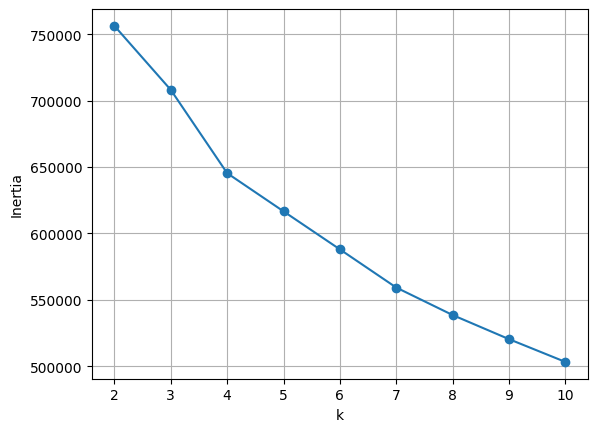

cluster
4    3002
6    2873
0    1756
3     462
2     273
1     181
5      12
Name: count, dtype: int64


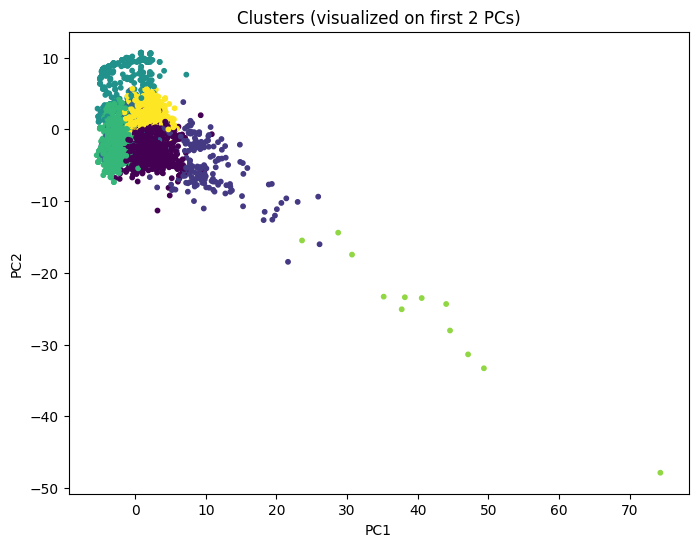

In [11]:
# Step 2: Find best K (silhouette + elbow)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil_scores = {}
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(df_pca)
    score = silhouette_score(df_pca, labels)
    sil_scores[k] = score
    print(f"k={k}, silhouette={score:.4f}")

best_k = max(sil_scores, key=sil_scores.get)
print("Best k by silhouette:", best_k)

# Elbow method
inertias = []
K_range = range(2, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(df_pca)
    inertias.append(km.inertia_)

plt.plot(K_range, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

# Step 3: Run final clustering (use best_k or adjust after elbow)
k = best_k
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(df_pca)

df_clustered = df_pca.copy()
df_clustered["cluster"] = cluster_labels
print(df_clustered["cluster"].value_counts())

# Step 4: Visualize clusters (PCA 2D plot)
plt.figure(figsize=(8, 6))
plt.scatter(df_pca["PC1"], df_pca["PC2"], c=cluster_labels, s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters (visualized on first 2 PCs)")
plt.show()


df_scaled: (8559, 140)
df_raw   : (8559, 140)

PCA results
Original: (8559, 140)
PCA     : (8559, 42)
Explained variance (total): 0.9500622397818946
Num components: 42
k=2, silhouette=0.1875, inertia=756199.67
k=3, silhouette=0.1989, inertia=708033.99
k=4, silhouette=0.2142, inertia=645351.20
k=5, silhouette=0.2143, inertia=616615.54
k=6, silhouette=0.1983, inertia=587982.69
k=7, silhouette=0.2262, inertia=559248.77
k=8, silhouette=0.2132, inertia=538553.78
k=9, silhouette=0.2204, inertia=520410.07
k=10, silhouette=0.2089, inertia=503264.80

Best k by silhouette: 7


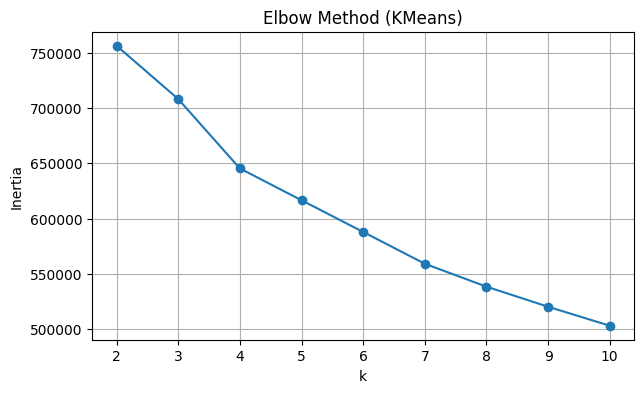

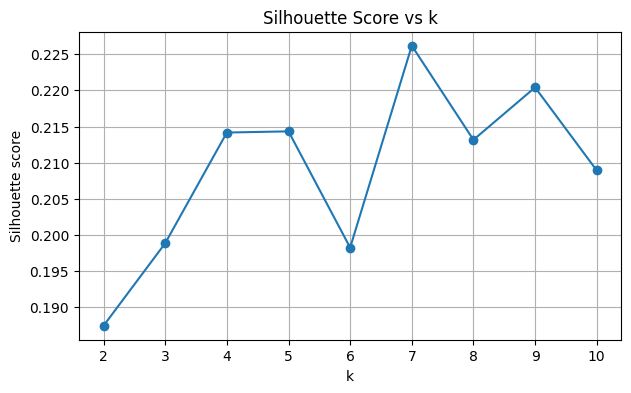


Cluster counts:
0    1756
1     181
2     273
3     462
4    3002
5      12
6    2873
Name: count, dtype: int64


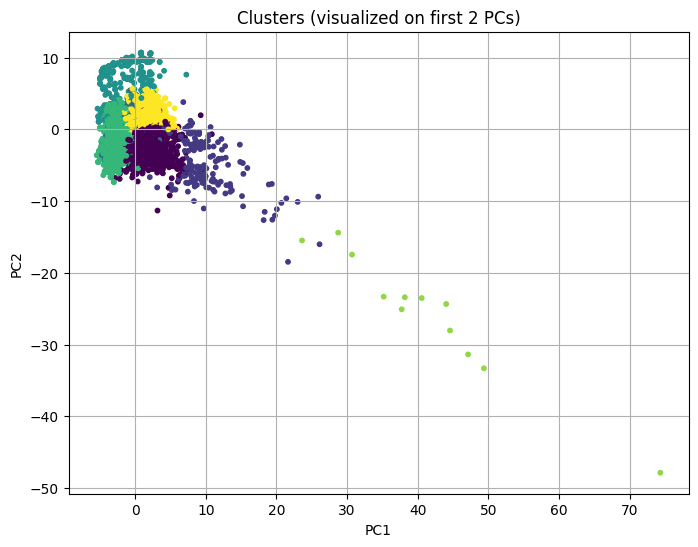


Saved: ../data/processed/raw_with_clusters.csv

Using numeric cols: []
Using flag cols   : ['has_website', 'has_phone', 'has_address', 'has_city', 'has_country', 'has_region']
Using cat cols    : []

Saved: ../data/processed/cluster_profile_summary.csv

=== Cluster Profile Summary (Pandas Table) ===


,size,has_website__pct,has_phone__pct,has_address__pct,has_city__pct,has_country__pct,has_region__pct,risk_score__mean
cluster,,,,,,,,
4,3002,6.1,3.8,100.0,98.8,100.0,100.0,1.90
6,2873,0.1,4.1,100.0,99.5,100.0,100.0,1.96
0,1756,22.0,73.6,99.9,100.0,100.0,100.0,1.04
3,462,0.0,0.0,26.4,0.2,100.0,100.0,2.74
2,273,2.2,2.9,100.0,98.9,100.0,100.0,1.95
1,181,24.3,71.8,98.9,99.4,100.0,100.0,1.05
5,12,33.3,100.0,100.0,100.0,100.0,100.0,0.67



=== Cluster Summary (Clean Report View) ===


,size,has_website__pct,has_phone__pct,has_address__pct,risk_score__mean
cluster,,,,,
4,3002,6.1,3.8,100.0,1.90
6,2873,0.1,4.1,100.0,1.96
0,1756,22.0,73.6,99.9,1.04
3,462,0.0,0.0,26.4,2.74
2,273,2.2,2.9,100.0,1.95
1,181,24.3,71.8,98.9,1.05
5,12,33.3,100.0,100.0,0.67


In [1]:
# ============================
# Full PCA -> KMeans -> Cluster Summary (Pandas display)
# ============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# If you're in a notebook, display() exists automatically.
# If you're running a .py script and want display(), uncomment these:
# from IPython.display import display


# ----------------------------
# 0) FILE PATHS (EDIT THESE)
# ----------------------------
SCALED_PATH = "../data/processed/features_for_clustering_scaled.csv"
RAW_PATH    = "../data/processed/features_for_clustering_raw.csv"   # change to your raw file path

OUT_RAW_WITH_CLUSTERS = "../data/processed/raw_with_clusters.csv"
OUT_CLUSTER_PROFILE   = "../data/processed/cluster_profile_summary.csv"


# ----------------------------
# 1) LOAD DATA
# ----------------------------
df_scaled = pd.read_csv(SCALED_PATH)
df_raw = pd.read_csv(RAW_PATH)

print("df_scaled:", df_scaled.shape)
print("df_raw   :", df_raw.shape)

if len(df_scaled) != len(df_raw):
    raise ValueError(
        f"Row mismatch! df_scaled has {len(df_scaled)} rows but df_raw has {len(df_raw)} rows. "
        "They must match row-by-row."
    )


# ----------------------------
# 2) PCA
# ----------------------------
# Keep 95% variance (recommended)
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(df_scaled)

df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])

print("\nPCA results")
print("Original:", df_scaled.shape)
print("PCA     :", df_pca.shape)
print("Explained variance (total):", float(np.sum(pca.explained_variance_ratio_)))
print("Num components:", pca.n_components_)


# ----------------------------
# 3) FIND BEST K (Silhouette + Elbow)
# ----------------------------
sil_scores = {}
inertias = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(df_pca)

    sil = silhouette_score(df_pca, labels)
    sil_scores[k] = sil
    inertias.append(km.inertia_)

    print(f"k={k}, silhouette={sil:.4f}, inertia={km.inertia_:.2f}")

best_k = max(sil_scores, key=sil_scores.get)
print("\nBest k by silhouette:", best_k)

# Elbow plot
plt.figure(figsize=(7, 4))
plt.plot(list(K_range), inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method (KMeans)")
plt.grid(True)
plt.show()

# Silhouette plot
plt.figure(figsize=(7, 4))
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Silhouette Score vs k")
plt.grid(True)
plt.show()


# ----------------------------
# 4) FINAL KMEANS CLUSTERING
# ----------------------------
k = best_k  # or set manually, e.g. k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(df_pca)

print("\nCluster counts:")
print(pd.Series(cluster_labels).value_counts().sort_index())


# ----------------------------
# 5) VISUALIZE CLUSTERS (PC1 vs PC2)
# ----------------------------
plt.figure(figsize=(8, 6))
plt.scatter(df_pca["PC1"], df_pca["PC2"], c=cluster_labels, s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters (visualized on first 2 PCs)")
plt.grid(True)
plt.show()


# ----------------------------
# 6) MERGE CLUSTERS BACK TO RAW DATA
# ----------------------------
df_raw_with_clusters = df_raw.copy()
df_raw_with_clusters["cluster"] = cluster_labels

df_raw_with_clusters.to_csv(OUT_RAW_WITH_CLUSTERS, index=False)
print("\nSaved:", OUT_RAW_WITH_CLUSTERS)


# ----------------------------
# 7) BUILD CLUSTER SUMMARY TABLE (PANDAS STYLE)
# ----------------------------

# A) numeric columns (use only those that exist)
candidate_numeric = ["Employees Single Site", "Employees Total", "Revenue (USD)"]
numeric_cols = [c for c in candidate_numeric if c in df_raw_with_clusters.columns]

# B) 0/1 flag columns (use only those that exist)
candidate_flags = ["has_website", "has_phone", "has_address", "has_city", "has_country", "has_region"]
flag_cols = [c for c in candidate_flags if c in df_raw_with_clusters.columns]

# C) categorical columns for "top value"
candidate_cats = ["Country", "Region", "Ownership Type", "Entity Type", "NAICS Description", "SIC Description"]
cat_cols = [c for c in candidate_cats if c in df_raw_with_clusters.columns]

print("\nUsing numeric cols:", numeric_cols)
print("Using flag cols   :", flag_cols)
print("Using cat cols    :", cat_cols)


def top_value(series: pd.Series):
    s = series.dropna()
    if len(s) == 0:
        return None
    return s.value_counts().index[0]


# Build profile
profile = df_raw_with_clusters.groupby("cluster").agg(size=("cluster", "count"))

# numeric stats
for col in numeric_cols:
    profile[f"{col}__mean"] = df_raw_with_clusters.groupby("cluster")[col].mean()
    profile[f"{col}__median"] = df_raw_with_clusters.groupby("cluster")[col].median()

# % flags
for col in flag_cols:
    profile[f"{col}__pct"] = (df_raw_with_clusters.groupby("cluster")[col].mean() * 100)

# top categorical
for col in cat_cols:
    profile[f"{col}__top"] = df_raw_with_clusters.groupby("cluster")[col].apply(top_value)

# risk score (optional)
needed_for_risk = ["has_website", "has_phone", "has_address"]
if all(c in df_raw_with_clusters.columns for c in needed_for_risk):
    df_raw_with_clusters["risk_score"] = (
        (1 - df_raw_with_clusters["has_website"]) +
        (1 - df_raw_with_clusters["has_phone"]) +
        (1 - df_raw_with_clusters["has_address"])
    )
    profile["risk_score__mean"] = df_raw_with_clusters.groupby("cluster")["risk_score"].mean()

# sort by size
profile = profile.sort_values("size", ascending=False)

# Nice rounding for display
profile_display = profile.copy()
for c in profile_display.columns:
    if "__mean" in c or "__median" in c:
        profile_display[c] = profile_display[c].round(2)
    if "__pct" in c:
        profile_display[c] = profile_display[c].round(1)
    if "risk_score" in c:
        profile_display[c] = profile_display[c].round(3)

# Save profile
profile_display.to_csv(OUT_CLUSTER_PROFILE)
print("\nSaved:", OUT_CLUSTER_PROFILE)


# ----------------------------
# 8) DISPLAY SUMMARY AS PANDAS TABLE
# ----------------------------
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

print("\n=== Cluster Profile Summary (Pandas Table) ===")
display(profile_display)

# Optional: show a cleaner "report view" with selected important columns only
important_cols = ["size"]

for col in ["Revenue (USD)__mean", "Revenue (USD)__median", "Employees Total__mean", "Employees Total__median"]:
    if col in profile_display.columns:
        important_cols.append(col)

for col in ["has_website__pct", "has_phone__pct", "has_address__pct"]:
    if col in profile_display.columns:
        important_cols.append(col)

for col in ["Country__top", "NAICS Description__top", "Ownership Type__top", "Entity Type__top"]:
    if col in profile_display.columns:
        important_cols.append(col)

if "risk_score__mean" in profile_display.columns:
    important_cols.append("risk_score__mean")

print("\n=== Cluster Summary (Clean Report View) ===")
display(profile_display[important_cols])


# ----------------------------
# 9) OPTIONAL: VIEW ONE CLUSTER'S RAW RECORDS
# ----------------------------
# Example: see cluster 0 companies
# display(df_raw_with_clusters[df_raw_with_clusters["cluster"] == 0].head(20))
